In [200]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [482]:
deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

servers = 2
server_kw = {
    'rng': rng,
    'service_rate': lambda rng: rng.choice([80]) * 1e3, # [W]
}

servers = [src.queuing.Server(**server_kw) for idx in range(servers)]

demand_kw = {
    'rng': rng,
    'max_length': 5,
    'inter_arrival': lambda rng: rng.exponential(600), # [Bool]
    'capacity': lambda rng: rng.normal(45, 0) * 3.6e6, # [J]
}

demand = src.queuing.Demand(**demand_kw)

system = src.queuing.System(servers, demand)

queue, served, status = system.simulate(steps = 10 * 3600, step = 60)

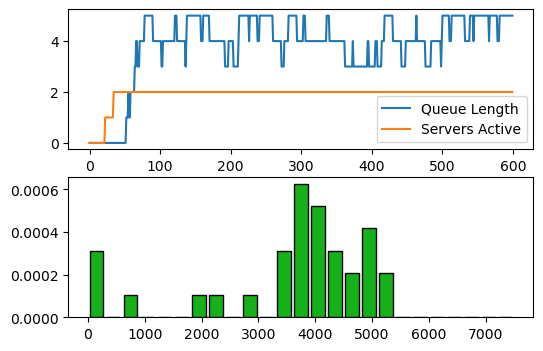

In [483]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(2, 1, figsize = (6, 4))

ax[0].plot(status['in_queue'], label = 'Queue Length')
ax[0].plot(status['in_service'], label = 'Servers Active')

ax[0].legend()

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(0, 7800, 300)),
    'density': True,
}

_ = ax[1].hist(steps, **kw)

In [486]:
deep_reload(src)

qt = []

for idx in range(100):

    kw = {
        'n': 5,
        'server': {
            'rng': rng,
            'service_rate': lambda rng: rng.choice([80]) * 1e3, # [W]
        },
        'demand': {
            'rng': rng,
            'inter_arrival': lambda rng: rng.exponential(600), # [Bool]
            'capacity': lambda rng: rng.normal(45, 0) * 3.6e6, # [J]
        },
        'simulation': {
            'steps': 10 * 3600,
            'step': 60,
        },
        'histogram': {
            'bins': list(range(0, 3600 * 10, 6)),
        },
    }

    qtd = src.queuing.queuing_time_distribution(**kw)
    qt.extend(list(qtd.rvs(size = 1000)))

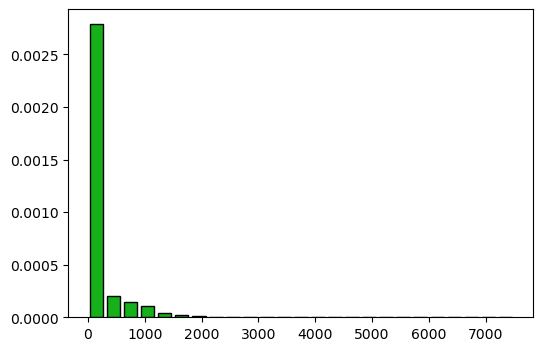

In [487]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(0, 7800, 300)),
    'density': True,
}

_ = ax.hist(qt, **kw)

In [257]:
qtd.rvs(size = 10)

array([   18.31782133, 14514.78662006, 17088.56251409,  4271.63984935,
        4366.32275567, 12365.19822477,  7923.90125855, 15086.24932801,
       16942.45094651, 13576.56392084])

In [547]:
deep_reload(src)

def qt_run(n, m, bins, iterations = 100):

    qt = []
    
    for idx in range(iterations):
    
        kw = {
            'n': n,
            'server': {
                'rng': rng,
                'service_rate': lambda rng: rng.choice([80]) * 1e3, # [W]
            },
            'demand': {
                'rng': rng,
                'max_length': 10,
                'initial': rng.integers(0, n + 1),
                'inter_arrival': lambda rng: rng.exponential(m), # [Bool]
                'capacity': lambda rng: rng.normal(45, 0) * 3.6e6, # [J]
            },
            'simulation': {
                'steps': 10 * 3600,
                'step': 60,
            },
            'histogram': {
                'bins': bins,
            },
        }
    
        qtd = src.queuing.queuing_time_distribution(**kw)
        qt.append(qtd.mean())

    return qt

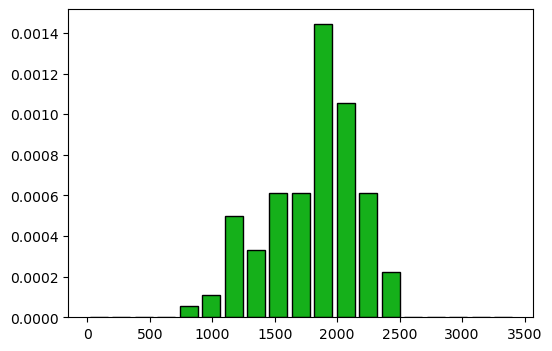

In [549]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(0, 3600, 180)),
    'density': True,
}

_ = ax.hist(qt_run(4, 300, kw['bins'], iterations = 100), **kw)

In [426]:
chargers = list(range(1, 15))
inter_arrival = 5
bins = list(range(60, 3600, 300))

values = []

for n in src.progress_bar.ProgressBar(chargers):

    val, _ = np.histogram(qt_run(n, inter_arrival, bins), bins = bins, density = True)
    values.append(val)

 [------------->] (14/14) 100.00%, 3.30 it/s, 4.54 s elapsed, 0.00 s remaining

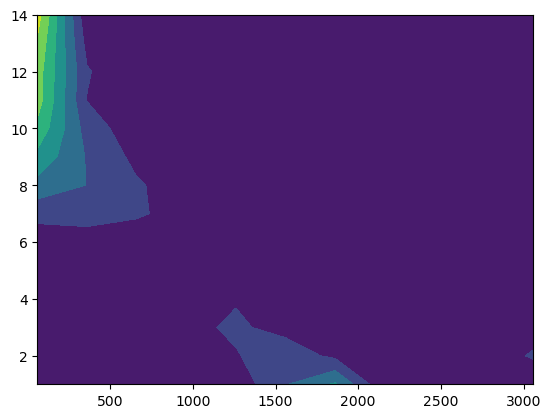

In [427]:
cg, bg = np.meshgrid(chargers, bins[:-1], indexing = 'ij')

plt.contourf(bg, cg, values)

In [425]:
values[0], values[-1]

(array([8.19000000e-05, 5.94666667e-05, 9.04666667e-05, 2.21966667e-04,
        2.84366667e-04, 7.34833333e-04, 8.40866667e-04, 1.47566667e-04,
        2.02433333e-04, 3.16333333e-04, 3.53133333e-04]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]))

In [446]:
deep_reload(src)

def qt_run(servers, service_time, rho, bins):

    arrival_rate = rho * servers * (1 / service_time)
    print(arrival_rate)

    qt = []
    
    for idx in range(100):
    
        kw = {
            'n': servers,
            'server': {
                'rng': rng,
                'service_rate': lambda rng: 1, # [W]
            },
            'demand': {
                'rng': rng,
                'spawn_criteria': lambda rng: rng.random() <= arrival_rate,
                'capacity': lambda rng: service_time, # [J]
            },
            'simulation': {
                'steps': 1440,
                'step': 1,
            },
            'histogram': {
                'bins': bins,
            },
        }
    
        qtd = src.queuing.queuing_time_distribution(**kw)
        qt.extend(list(qtd.rvs(size = 1000)))

    return qt

0.13333333333333333


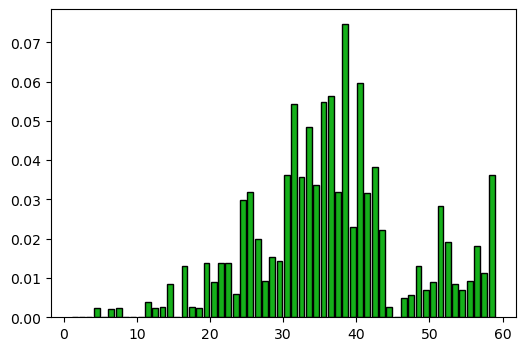

In [447]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(1, 60, 1)),
    'density': True,
}

_ = ax.hist(qt_run(2, 45, 3, kw['bins']), **kw)